In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.externals import joblib
from scipy.sparse import hstack
%matplotlib inline

In [2]:
df_news = pd.read_csv('../data/news_headlines.csv')
df_news.publish_date = pd.to_datetime(df_news.publish_date, format='%Y%m%d')
df_news['publish_year'] = df_news.publish_date.dt.year
df_news.sort_values('publish_date', inplace=True)
print('Rows: {}'.format(df_news.shape[0]))
df_news.head()

Rows: 1000001


,publish_date,headline_text,publish_year
23668,2003-02-19,surge in new car sales in aust abs,2003
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003
8208,2003-02-19,nsw opp defends claims of running race campaign,2003
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003
20646,2003-02-19,sterrey to steer sharks,2003


### Checking for duplicates in dataset

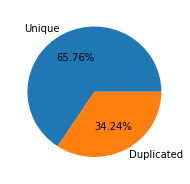

In [3]:
df_news.duplicated().map({True: 'Duplicated', False: 'Unique'}).value_counts().plot(
    kind='pie', autopct='%.2f%%', figsize=(3, 3), label='')

Example of duplicated

In [4]:
df_news.loc[df_news.headline_text == 'mans body found in river murray mannum']

,publish_date,headline_text,publish_year
968711,2017-07-03,mans body found in river murray mannum,2017
976437,2017-07-03,mans body found in river murray mannum,2017


In [5]:
df_news.drop_duplicates(inplace=True)

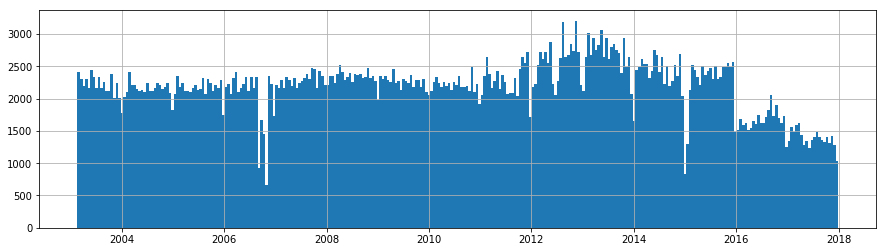

In [6]:
fig, ax = plt.subplots(figsize=(15,4))
df_news.publish_date.hist(ax=ax, bins=300);

# Pre processing text

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

def pre_processing(text):
    words = word_tokenize(text.lower(), language='english')
    words = [w for w in words if not w in stopwords]  # Remove stop words
    words = [w for w in words if not w in string.punctuation]  # Remove pontuacao
    words = [stemmer.stem(w) for w in words]  # Extrai radical da palavra
    return ' '.join(words)
def n_grams(text,n):
    words = word_tokenize(text.lower(), language='english')
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    words = ['-'.join(words[i]) for i in range(len(words))]
    return ' '.join(words)
def char_ngrams(text,n):
    words = ''.join(text.lower().split())
    words = [words[i:i+n] for i in range(len(words)-n+1)]
    return ' '.join(words)



In [8]:
tic = time.time()

df_news['text'] = df_news.headline_text.apply(pre_processing)
df_news['2_grams'] = df_news.text.apply(lambda x: n_grams(x,2))
df_news['3_grams'] = df_news.text.apply(lambda x: n_grams(x,3))
df_news['4_chargrams'] = df_news.text.apply(lambda x: char_ngrams(x,4))

toc = time.time()
print('Elapsed time on text pre-processing: %d minutes and %d seconds.' % ((toc-tic)/60,(toc-tic)%60))
df_news.head()

Elapsed time on text pre-processing: 4 minutes and 59 seconds.


,publish_date,headline_text,publish_year,text,2_grams,3_grams,4_chargrams
23668,2003-02-19,surge in new car sales in aust abs,2003,surg new car sale aust ab,surg-new new-car car-sale sale-aust aust-ab,surg-new-car new-car-sale car-sale-aust sale-a...,surg urgn rgne gnew newc ewca wcar cars arsa r...
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003,new zealand impos visa entri zimbabw,new-zealand zealand-impos impos-visa visa-entr...,new-zealand-impos zealand-impos-visa impos-vis...,newz ewze wzea zeal eala alan land andi ndim d...
8208,2003-02-19,nsw opp defends claims of running race campaign,2003,nsw opp defend claim run race campaign,nsw-opp opp-defend defend-claim claim-run run-...,nsw-opp-defend opp-defend-claim defend-claim-r...,nswo swop wopp oppd ppde pdef defe efen fend e...
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003,qanta war plan cut 2500 job outrag union,qanta-war war-plan plan-cut cut-2500 2500-job ...,qanta-war-plan war-plan-cut plan-cut-2500 cut-...,qant anta ntaw tawa awar warp arpl rpla plan l...
20646,2003-02-19,sterrey to steer sharks,2003,sterrey steer shark,sterrey-steer steer-shark,sterrey-steer-shark,ster terr erre rrey reys eyst yste stee teer e...


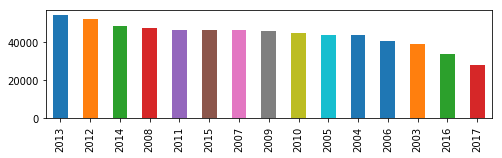

In [9]:
df_news.publish_year.value_counts().plot(kind='bar', figsize=(8, 2))

In [10]:
df_news.to_pickle('df_news.pkl')

# Feature extraction

### Using entire dataset:

In [2]:
from sklearn.externals import joblib

df_news = joblib.load('df_news.pkl')

In [3]:
df_news = df_news.reset_index().drop('index', axis=1)

In [13]:
sentences = df_news.text.map(lambda x: x.split())

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(sentences, min_count=50,size=300,workers=4)

In [15]:
def invocab(sentence):
    x = []
    for i in range(len(sentence)):
        if(sentence[i] in model.wv.vocab.keys()):
            x.append(sentence[i])
    return x

In [16]:
texts = sentences.map(lambda x: invocab(x))

In [17]:
features = np.zeros((texts.shape[0],300))
for i,text in enumerate(texts):
    if len(text) != 0:
        feats = model.wv[text].sum(axis=0)
        features[i] = feats
    else:
        feats = np.zeros((300,))
        features[i] = feats

In [18]:
from sklearn.preprocessing import normalize

features = normalize(features)

In [19]:
joblib.dump(features,'features.pkl')

['features_.pkl']

# Clustering:

In [4]:
features = joblib.load('features.pkl')

In [5]:
def validity(model, N):
    intra = (model.inertia_ / N)
    centers = model.cluster_centers_
    flag = 1e10
    for i in range(centers.shape[0]):
        for j in range(i+1, centers.shape[0]):
            distance = paired_distances(centers[i].reshape(-1,1),centers[j].reshape(-1,1)).sum()
            if distance<flag:
                flag=distance
    inter = flag
    return intra/inter

### Estimating number of clusters:

In [6]:
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances
use_cache = True

inertias, scores, sils, val = [], [], [], []
n_clusters = range(2,31,1)
N = features.shape[0]
for n_cluster in n_clusters:
    tic = time.time()
    cluster_path = os.path.join('KMeans', 'KMeans_w2v_batch50{}.pkl'.format(n_cluster))
    if not use_cache or not os.path.exists(cluster_path):
        cluster = KMeans(n_cluster, random_state=42, max_iter = 300, n_jobs=-1)
        cluster.fit(features)
        joblib.dump(cluster, cluster_path)
    else:
        cluster = joblib.load(cluster_path)
    inertias.append(cluster.inertia_)
    scores.append(cluster.score(features))  
    sils.append(silhouette_score(features, cluster.labels_, random_state=42, sample_size=5000))
    val.append(validity(cluster,N))
    print('Number of clusters: %d' % n_cluster)
toc = time.time()
print('Elapsed time: %d hours, %d minutes and %d seconds' % ((toc-tic)/3600,((toc-tic)/60)%60,(toc-tic)%60))


Number of clusters: 2
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5
Number of clusters: 6
Number of clusters: 7
Number of clusters: 8
Number of clusters: 9
Number of clusters: 10
Number of clusters: 11
Number of clusters: 12
Number of clusters: 13
Number of clusters: 14
Number of clusters: 15
Number of clusters: 16
Number of clusters: 17
Number of clusters: 18
Number of clusters: 19
Number of clusters: 20
Number of clusters: 21
Number of clusters: 22
Number of clusters: 23
Number of clusters: 24
Number of clusters: 25
Number of clusters: 26
Number of clusters: 27
Number of clusters: 28
Number of clusters: 29
Number of clusters: 30
Elapsed time: 0 hours, 0 minutes and 2 seconds


In [7]:
import numpy as np

def plot(name, data, line_func=None):
    fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12, 5))
    ax.plot(n_clusters, data)
    if line_func:
        ax.axvline(n_clusters[line_func(data)], color='gray', alpha=0.3)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel(name)
    ax.set_title('Elbow method')
    plt.xticks(n_clusters)

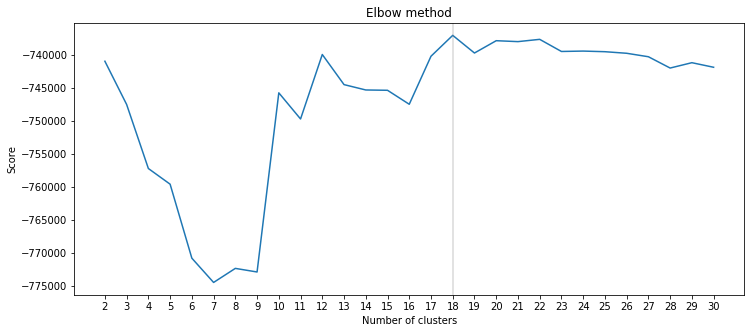

In [8]:
plot('Score', scores, np.argmax)

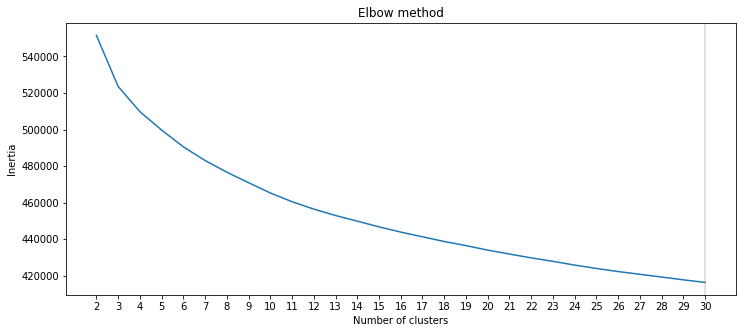

In [9]:
plot('Inertia', inertias, np.argmin)

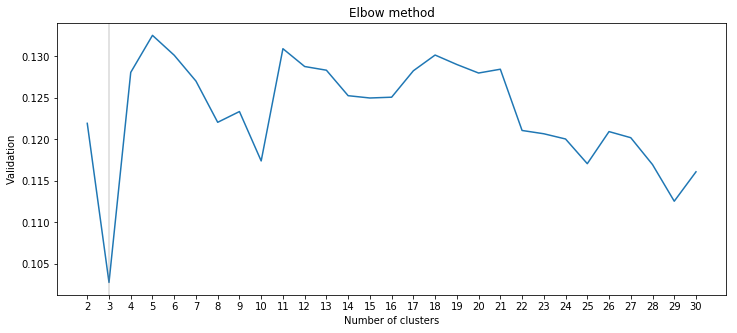

In [10]:
plot('Validation', val, np.argmin)

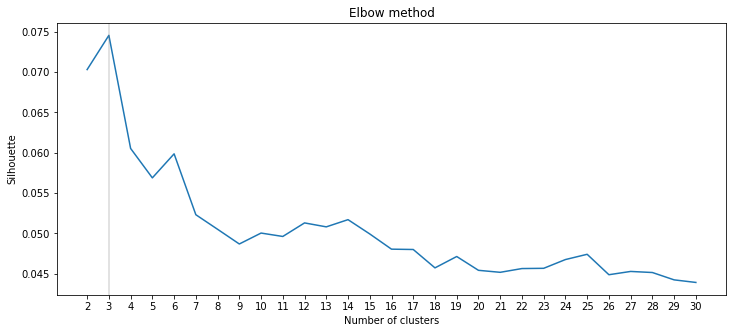

In [11]:
plot('Silhouette', sils, np.argmax)

In [12]:
print('Ideal number of clusters, based on silhouete and inertia analysis: 6')

Ideal number of clusters, based on silhouete and inertia analysis: 6


# Definition of label names

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

def most_frequent(texts, n=10):
        counts = CountVectorizer(max_features=n, token_pattern=r'\w+-*\w+-*\w+')
        counts.fit_transform(texts)
        return [key for key in counts.vocabulary_]

In [33]:
cluster_path = "KMeans/KMeans_w2v_batch506.pkl"
cluster = joblib.load(cluster_path)
features = joblib.load('features.pkl')

In [34]:
df_news['cluster'] = cluster.predict(features)

#### Cluster 0:

In [35]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==0], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==0].head(10))

Top 10 words:
['releas', 'appeal', 'hospit', 'find', 'say', 'studi', 'polic', 'report', 'court', 'show']


Top 10 2-grams:
['report-find', 'court-told', 'high-court', 'high-school', 'help-find', 'bodi-found', 'kohler-report', 'find-miss', 'royal-commiss', 'studi-find']


Top 10 3-grams:
['bodi-found-near', 'find-miss-man', 'help-find-miss', 'seek-help-find', 'polic-seek-help', 'hospit-wait-list', 'cctv-footag-show', 'polic-appeal-help', 'find-miss-woman', 'appeal-help-find']


10 examples of headines:
107           mp raises hospital concerns in parliament
164                     nats seek probe bushfires probe
211       lawyers to review case before any esso appeal
235       police continue probe into human remains find
241      coronial inquiry expected after hospital death
266              qld govt says new hospital on schedule
283       male dna found on body of murdered schoolgirl
317    british govt clashes with high court over asylum
339        llewellyn not impressed by patters

A label for this cluster group is: X

#### Cluster 1:

In [36]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==1], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==1].head(10))

Top 10 words:
['decis', 'consid', 'face', 'council', 'say', 'water', 'mine', 'develop', 'school', 'plan']


Top 10 2-grams:
['council-consid', 'basin-plan', 'alic-spring', 'coal-mine', 'wast-dump', 'darl-basin', 'studi-consid', 'council-seek', 'green-light', 'murray-darl']


Top 10 3-grams:
['face-uncertain-futur', 'move-closer-realiti', 'murray-darl-basin', 'mcarthur-river-mine', 'murray-darl-plan', 'darl-basin-plan', 'juri-retir-consid', 'back-win-way', 'council-de-merger', 'coal-seam-gas']


10 examples of headines:
31          radioactive spill at wmcs olympic dam mine
38     williams says tight bowling key to warriors win
57      juvenile sex offenders unlikely to reoffend as
96               irrigators vote over river management
114                swiss challengers looking to future
220         no funding discussion until after nsw poll
232            school to reopen after paint fume scare
249          meetings to consider glenelg river future
310               g g to witness ch

A label for this cluster group is: <b>X</b>

#### Cluster 2:

In [37]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==2], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==2].head(10))

Top 10 words:
['man', 'council', 'back', 'charg', 'fire', 'urg', 'plan', 'interview', 'polic', 'say']


Top 10 2-grams:
['climat-chang', 'asylum-seeker', 'man-jail', 'rate-rise', 'man-charg', 'face-court', 'polic-investig', 'world-cup', 'plead-guilti', 'polic-probe']


Top 10 3-grams:
['one-plus-one', 'man-front-court', 'great-barrier-reef', 'front-court-accus', 'rural-qld-podcast', 'child-sex-abus', 'abc-entertain-news', 'man-plead-guilti', 'man-face-court', 'child-sex-charg']


10 examples of headines:
2      nsw opp defends claims of running race campaign
3     qantas war plan to cut 2500 jobs outrages unions
4                              sterrey to steer sharks
7               more women urged to become councillors
12               stop changing the rules fans tell afl
13               shire offers assurances over finances
17      rfs rejects claim that act authorities spurned
18    talk of asian nuclear arms race unhelpful downer
21         kelly disgusted at alleged bp ethanol s

A label for this cluster group is: <b>X</b>

#### Cluster 3:

In [38]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==3], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==3].head(10))

Top 10 words:
['save', 'rural', 'nation', 'hour', 'win', 'show', 'lead', 'fund', 'award', 'news']


Top 10 2-grams:
['broken-hill', 'fund-boost', 'countri-hour', 'qld-countri', 'rural-quarter', 'age-care', 'news-wednesday', 'nation-rural', 'rural-news', 'news-thursday']


Top 10 3-grams:
['rural-news-thursday', 'age-care-centr', 'qld-countri-hour', 'age-care-facil', 'rural-qld-rural', 'qld-rural-report', 'mental-health-fund', 'age-care-fund', 'rural-news-wednesday', 'nation-rural-news']


10 examples of headines:
1566                       coetzer wins again in acapulco
1625                            kucera wins in copenhagen
2460      nsw govt announces mater cancer treatment funds
2499    commonwealth threatens to withdraw forestry funds
2633           govts reach douglas arterial rd compromise
3168                           roff leads brumbies to win
3392                       aged care funds under question
3928                             hospice funding resolved
4089             

A label for this cluster group is: <b>X</b>

#### Cluster 4:

In [39]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==4], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==4].head(10))

Top 10 words:
['new', 'miss', 'health', 'market', 'death', 'kill', 'govt', 'call', 'australian', 'australia']


Top 10 2-grams:
['health-servic', 'south-africa', 'hour-podcast', 'new-zealand', 'search-miss', 'north-korea', 'mental-health', 'countri-hour', 'media-call', 'share-market']


Top 10 3-grams:
['tas-countri-hour', 'countri-hour-podcast', 'busi-news-market', 'australian-share-market', 'nsw-countri-hour', 'abc-busi-news', 'sa-countri-hour', 'vic-countri-hour', 'wa-countri-hour', 'news-market-analysi']


10 examples of headines:
0                   surge in new car sales in aust abs
1          new zealand imposes visa entry for zimbabwe
6            worksafe probes potato harvester injuries
9     unions to ask members to support public protests
10           six palestinians killed in gaza incursion
15                record amount for gladstone ventures
16     peace agreement may bring respite for venezuela
19               girl injured in head on highway crash
20                 

A label for this cluster group is: <b>X</b>

#### Cluster 5:

In [40]:
print('Top 10 words:')
print(most_frequent(df_news.text.loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 2-grams:')
print(most_frequent(df_news['2_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('Top 10 3-grams:')
print(most_frequent(df_news['3_grams'].loc[df_news.cluster==5], 10))
print('\n')
print('10 examples of headines:')
print(df_news.headline_text.loc[df_news.cluster==5].head(10))

Top 10 words:
['set', 'year', 'court', 'win', 'crash', 'cup', 'drug', 'gold', 'new', 'forc']


Top 10 2-grams:
['rural-news', 'live-stream', 'nation-rural', 'broken-hill', 'grand-final', 'gold-coast', 'world-cup', 'plane-crash', 'high-court', 'court-hear']


Top 10 3-grams:
['ash-test-day', 'nation-rural-news', 'live-stream-updat', 'light-plane-crash', 'afl-live-stream', 'man-front-court', 'test-day-two', 'test-day-one', 'nrl-live-stream', 'rugbi-world-cup']


10 examples of headines:
5                  refshauge wins defamation court case
8                  teen to face court over drug charges
11                           bathhouse plans move ahead
14    aussie qualifier stosur wastes four memphis match
24             meeting to consider tick clearance costs
33        man arrested after central qld hijack attempt
43        martin to lobby against losing nt seat in fed
75          massive drug crop discovered in western nsw
77               gold coast to hear about bilby project
87    

A label for this cluster group is: <b>X</b>